In [6]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

# Num answers

In this notebook, we document our various steps taken to study the effect of the overall length of a session on the number of answers to the very first comment. Note that we only do this on a sample of 1 mio. data points here.

In [7]:
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [8]:
nrow(data)

[1] 1000000

## Data inspection

We start by getting a better feeling of our data. Note that num_answers represents count data.

We limit the data to only consider the first comment of each session.

In [9]:
idx = data$session_index==1

In [10]:
data_first = data[idx,]

In [5]:
nrow(data_first)

[1] 502586

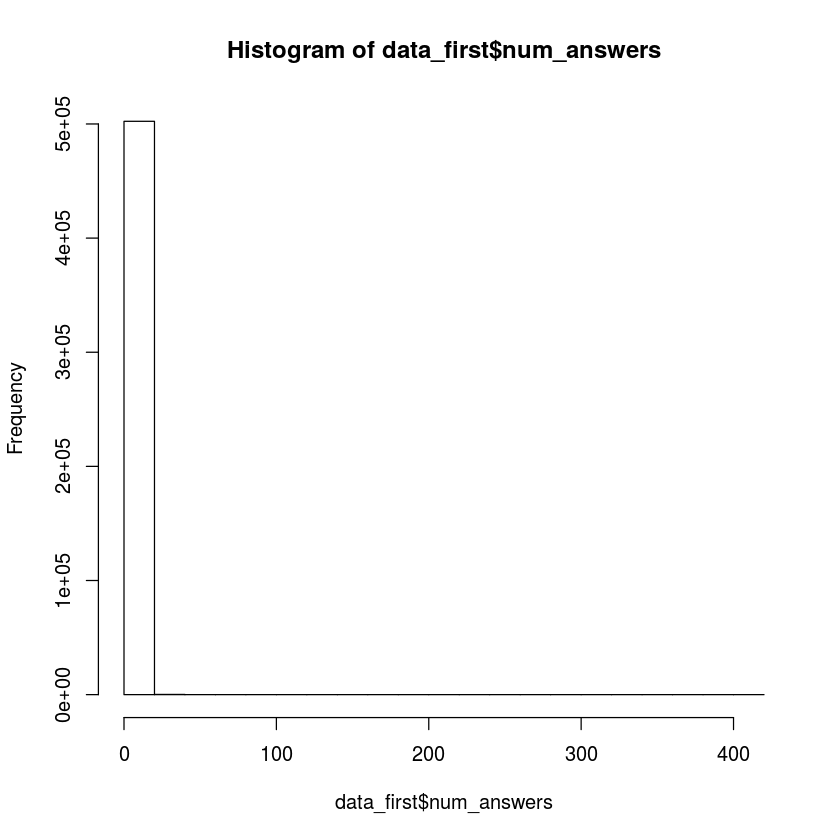

In [6]:
hist(data_first$num_answers)

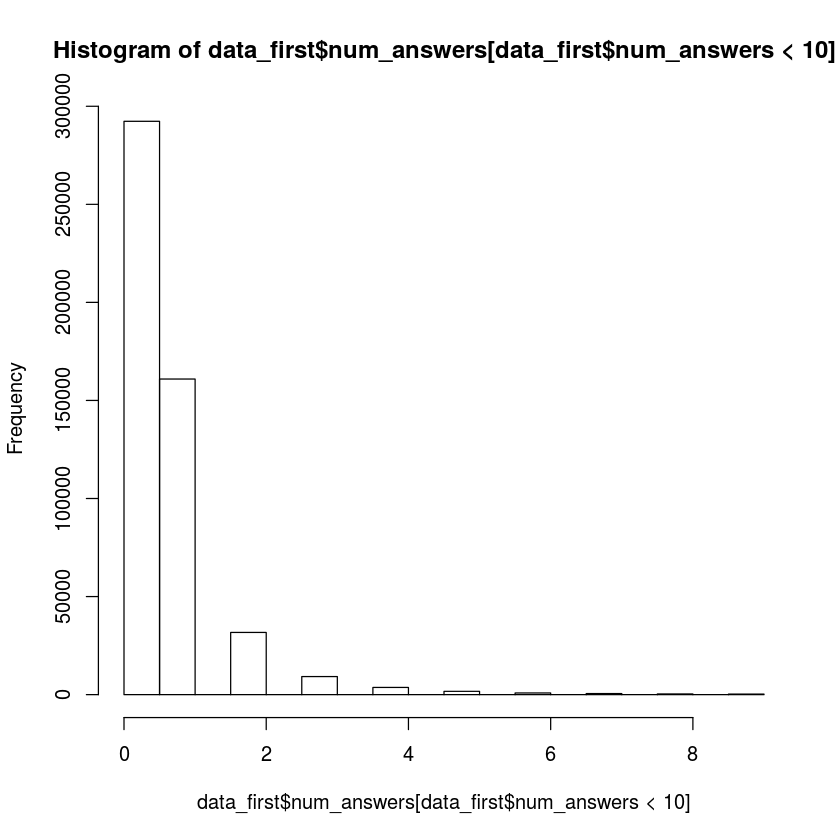

In [8]:
hist(data_first$num_answers[data_first$num_answers<10])

## Regression model

We use mixed-effects models where in the most basic form (that we analyze in this notebook), we are interested in studying num_answers ~ 1 + session_comments + (1|author) where num_answers is the number of answers the first comment receives, session_comments refers to the session length and author represents the redditor username.

### Linear mixed-effects regression

Even though we cannot expect a simple linear mixed-effects regression to be an appropriate model for our count data, we start with it.

In [11]:
m_lmer = lmer(num_answers~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [12]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: num_answers ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1880744.8 1880789.3 -940368.4 1880736.8    502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -6.924  -0.364  -0.336   0.243 253.650 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.2116   0.460   
 Residual             2.2650   1.505   
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      0.5854271  0.0026527  220.69
session_comments 0.0143290  0.0006883   20.82

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.509

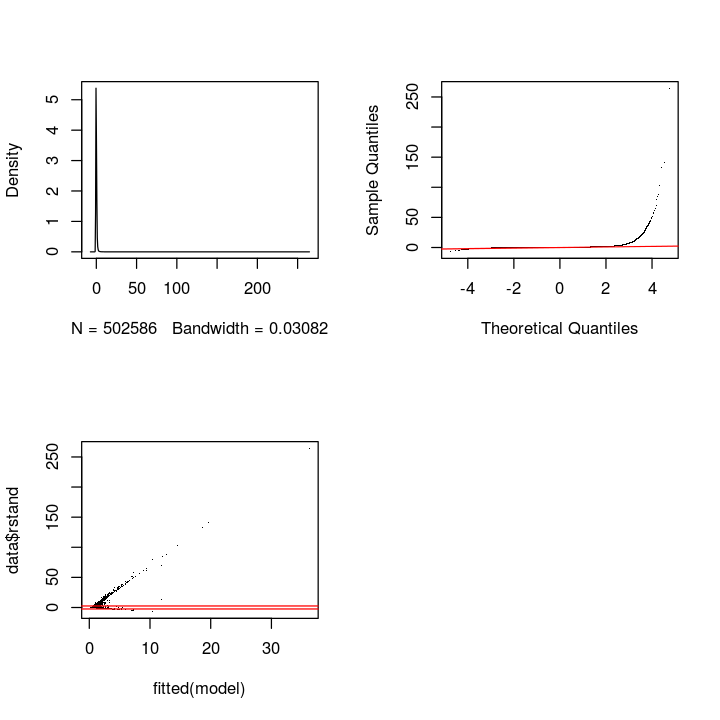

In [13]:
mcp.fnc(m_lmer)

What we can see in above plot is, that the residuals do not appear to be normally distributed and we can see clear heteroskedasticity. Thus, as expected, a linear model does not provide a good fit here.

### Linear mixed-effects regression (log-transform)

Next, let us take the log of the response variable and repeat a linear regression.

In [14]:
m_lmer_log = lmer(log1p(num_answers)~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [15]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log1p(num_answers) ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
 634837.9  634882.4 -317414.9  634829.9    502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3139 -0.7349 -0.7072  0.7568 12.2594 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.008364 0.09146 
 Residual             0.198821 0.44589 
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      0.3348665  0.0007609   440.1
session_comments 0.0066275  0.0001989    33.3

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.517

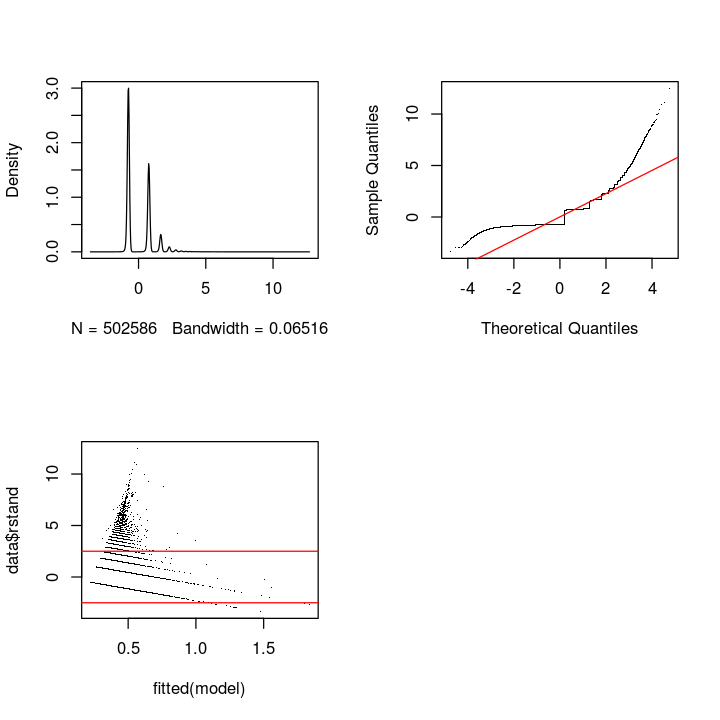

In [16]:
mcp.fnc(m_lmer_log)

That does not look satisfying at all. We should focus on generalized mixed-effects models to better model the count data.

### Poisson GLMER

Let us start with a Poisson GLMER, which is a main choice when working with count data.

In [11]:
m_poisson = glmer(num_answers~1+session_comments+(1|author),data=data_first,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [12]:
summary(m_poisson)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1062324.5 1062357.9 -531159.2 1062318.5    502583 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6406 -0.5951 -0.5518  0.5778 11.6484 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.5935   0.7704  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.8447537  0.0030912 -273.28   <2e-16 ***
session_comments  0.0168852  0.0005258   32.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.360
convergence code: 0
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?


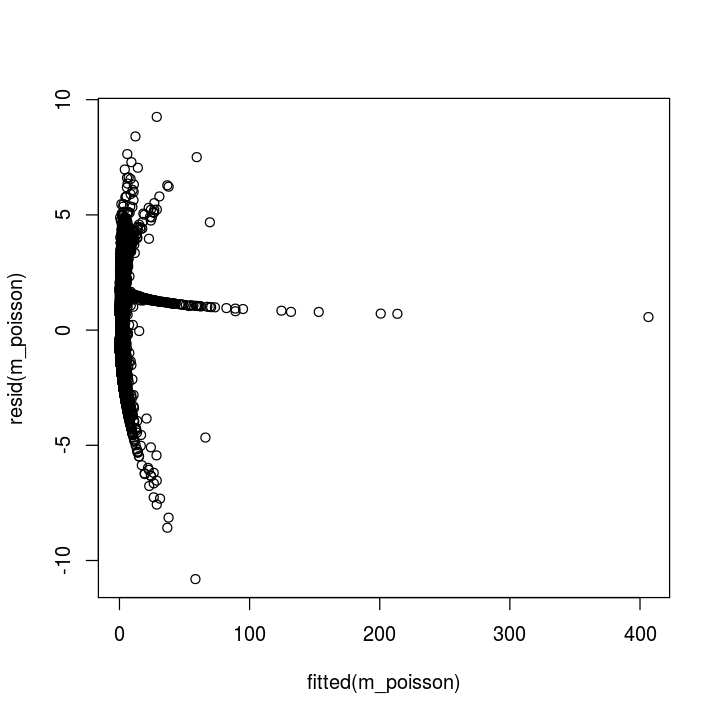

In [13]:
plot(fitted(m_poisson),resid(m_poisson))

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The residual plots for generalized linear models are generally quite difficult to interpret as the residuals do not necessarily need to follow a normal distribution any longer. However, the fitted vs. residual plots shows a typical pattern for Poisson regression with curvilinear traces. What we can do though as a first step here, is to look at overdispersion (see http://glmm.wikidot.com/faq).

In [21]:
overdisp_fun <- function(model) {
  ## number of variance parameters in 
  ##   an n-by-n variance-covariance matrix
  vpars <- function(m) {
    nrow(m)*(nrow(m)+1)/2
  }
  model.df <- sum(sapply(VarCorr(model),vpars))+length(fixef(model))
  rdf <- nrow(model.frame(model))-model.df
  rp <- residuals(model,type="pearson")
  Pearson.chisq <- sum(rp^2)
  prat <- Pearson.chisq/rdf
  pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
  c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

In [22]:
overdisp_fun(m_poisson)

chisq        ratio          rdf            p 
3.161706e+05 6.290913e-01 5.025830e+05 1.000000e+00

It does not seem that we have any problem with overdispersion here.

Let us be sure and check it with the dispersion_glmer function from the blmeco packages. 

In [23]:
library("blmeco") 
dispersion_glmer(m_poisson)

[1] 0.9746933

The value is between 0.75 and 1.4 which gives an indicator that there is no overdispersion problem.

What might be an issue for our model though, is the vast presence of zeros in our data. In order to tackle this issue, one can look at zero-inflated Poisson models. Unfortunately, these are only implemented in the MCMCglmm and glmmADMB packages which both utilize complex fitting methods that do not scale to large data and are thus, not useful for our large data case. 

To that end, we use a generic "implementation of the EM algorithm that alternates between fitting a GLMM with data that are weighted according to their zero probability, and fitting a binary FLM for the probability that a data point is zero"---for detailed reference please refer to https://groups.nceas.ucsb.edu/non-linear-modeling/projects/owls/WRITEUP/owls.pdf. 

In [25]:
source("owls_R_funs.R")

In [26]:
m_poisson_zi = zipme(cformula=num_answers~1+session_comments+(1|author), zformula=z~1,data=data_first,cfamily=poisson())

itr: 1 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 2 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00109253 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 3 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00190655 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 4 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00179033 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 5 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 6 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 7 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 8 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 9 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00245394 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 10 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00131125 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 11 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00108087 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 12 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 13 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 14 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00127574 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 15 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00137723 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 16 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 17 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 18 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 19 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00182841 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

itr: 20 


Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00149424 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [27]:
summary(m_poisson_zi)

          Length Class    Mode   
zfit          30 glm      list   
cfit           1 glmerMod S4     
itr            1 -none-   numeric
deltainfo     20 -none-   numeric
z         502586 -none-   numeric

In [28]:
summary(m_poisson_zi$cfit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments + (1 | author)
   Data: bydataw
Weights: (1 - z)

      AIC       BIC    logLik  deviance  df.resid 
1039777.5 1039810.9 -519885.7 1039771.5    502583 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.2167 -0.5918 -0.5506  0.5525  9.8591 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.5749   0.7583  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.8048692  0.0030773 -261.55   <2e-16 ***
session_comments  0.0173491  0.0005341   32.48   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.366
convergence code: 0
Model failed to converge with max|grad| = 0.00149424 (tol = 0.001, component 1)
Model is n

Even though we see some convergence warnings (low magnitude, for each iteration), we can see is that the coefficients are very similar to the model fitted without zero-inflation. Comparing the BIC thoughs reveals a better fit in general for the ZIP.

Again, for completeness, we fit a negative binomial regression with quasi likelihood.

In [29]:
#just for initialization
init = glm.nb(num_answers~1+session_comments,data=data_first)

In [30]:
init$theta

[1] 1.190964

In [31]:
m_pql_nb = glmmPQL(num_answers~1+session_comments, random = list(~1 | author), data = data_first, family = negative.binomial(theta=init$theta))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [33]:
summary(m_pql_nb)

Linear mixed-effects model fit by maximum likelihood
 Data: data_first 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | author
        (Intercept)  Residual
StdDev:   0.7641186 0.7000934

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: num_answers ~ 1 + session_comments 
                      Value    Std.Error     DF   t-value p-value
(Intercept)      -0.8016430 0.0024112393 370779 -332.4610       0
session_comments  0.0191173 0.0005156257 131805   37.0759       0
 Correlation: 
                 (Intr)
session_comments -0.428

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-2.1827040 -0.7311966 -0.6719062  0.5634574  9.3199213 

Number of Observations: 502586
Number of Groups: 370780 

Again, very similar results.

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we can conclude that all have very similar conclusions, namely that the session length has a positive effect on num_answers of the first comment in the session. Probably, the most appropriate model would be the zero-inflated Poisson regression. However, as the simple Poisson regression scales much better for larger data, we will continue to use it from this point on. Also, we do not use quasi likelihood, as it is difficult to compare the significance of fixed and random effects as no likelihood can be given; yet, it is reassuring that the coefficients are very similar to the Poisson models.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

num_answers = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [34]:
m1 = glmer(num_answers~1+(1|author), data = data_first, family=poisson())

In [35]:
summary(m1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1063255.8 1063278.0 -531625.9 1063251.8    502584 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6740 -0.5990 -0.5549  0.5647 11.6432 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.5946   0.7711  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.811590   0.002891  -280.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Next, let us incorporate the session length.

In [36]:
m2 = glmer(num_answers~1+session_comments+(1|author), data = data_first, family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [37]:
summary(m2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1062324.5 1062357.9 -531159.2 1062318.5    502583 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6406 -0.5951 -0.5518  0.5778 11.6484 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.5935   0.7704  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.8447537  0.0030912 -273.28   <2e-16 ***
session_comments  0.0168852  0.0005258   32.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.360
convergence code: 0
Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?


Based on the lower BIC we can clearly see that the incorporation of the session_comments improves our model, thus, we make inference on it (also the t-value indicates high significance).

We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [41]:
m3 = glmer(num_answers~1+session_comments+(1|author)+(1|subreddit), data = data_first, family=poisson())

Warning message:
: extra argument(s) ‘REML’ disregardedWarning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [42]:
summary(m3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments + (1 | author) + (1 | subreddit)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1062029.2 1062073.7 -531010.6 1062021.2    502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.9740 -0.6411 -0.5841  0.5175 12.4490 

Random effects:
 Groups    Name        Variance Std.Dev.
 author    (Intercept) 0.53747  0.7331  
 subreddit (Intercept) 0.01124  0.1060  
Number of obs: 502586, groups:  author, 370780; subreddit, 13987

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.8459987  0.0042272 -200.13   <2e-16 ***
session_comments  0.0163897  0.0005214   31.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.243
convergence code: 0
Model is nearly unide

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed effects does not change. For complexity reasons, we neglect the random effect for the subreddit for the complete data.